In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random

def dag(X):
    return X.conj().T

# This function reduces arrays which are only composed by one element to scalars.
def sq(x):
    return np.squeeze(x)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Parameters.
Ω = 1. # Rabi frequency
δ = 0.3 # Dephasing
θR = 0 # Parameter (must be zero to have a linear GKSL evolution)
θL = 0 # Parameter (must be zero to have a linear GKSL evolution)
γR = 1 # Bath coupling strength
γL = 1 # Bath coupling strength
βR = 0.8 # Inverse temperature of the thermal bath
βL = 1 # Inverse temperature of the thermal bath
# TODO: better define the following two parameters
ωR = 1 # Atom transition frequency
ωL = 1 # Atom transition frequency
dt = 0.001
t_max = 10

# Bose-Einstein Nbar calculation (Landi et al. 2023)
NbarR = 1. / (np.exp(-βR * ωR) - 1.)
NbarL = 1. / (np.exp(-βL * ωL) - 1.)

t_range = np.arange(0, t_max, dt)

# Loads Pauli matrices.
σx = np.array([[0,1],[1,0]], dtype="complex128")
σy = np.array([[0, -1j],[1j,0]], dtype="complex128")
σz = np.array([[1,0],[0,-1]], dtype="complex128")

# And raising and lowering operators.
σp = np.array([[0,0],[1,0]], dtype="complex128")
σm = dag(σp)

# And the identity matrix.
ide = np.array([[1,0],[0,1]], dtype="complex128")
# And the zero matrix
zero = np.array([[0,0],[0,0]], dtype="complex128")

L_Rin = NbarR * γR * σp
L_Rout = (NbarR + 1) * γR * σm
L_Lin = NbarL * γL * σp
L_Lout = (NbarL + 1) * γL * σm

H = Ω * σx + δ * σz

In [3]:
def execute_step(ψ0, ϕR0, ϕL0, SR0, SL0, print_jumps=False):
    # Note that this uses the SSE (not the SME) version of the stochastic evolution of the monitoring vector (see Albarelli et al. 2018).
    ρ = ψ0 @ dag(ψ0)
    
    # Computes the value of H in the perturbative dynamics.
    Hθ = (1 + θR + θL) * H
    
    # Computes the value of the jump operators coefficients in the perturbative dynamics.
    l_Rin = (np.trace(L_Rin @ ρ @ dag(L_Rin)) - np.trace(L_Rout @ ρ @ dag(L_Rout))) / (np.trace(L_Rin @ ρ @ dag(L_Rin)) + np.trace(L_Rout @ ρ @ dag(L_Rout)))
    l_Rout = - l_Rin
    l_Lin = (np.trace(L_Lin @ ρ @ dag(L_Lin)) - np.trace(L_Lout @ ρ @ dag(L_Lout))) / (np.trace(L_Lin @ ρ @ dag(L_Lin)) + np.trace(L_Lout @ ρ @ dag(L_Lout)))
    l_Lout = - l_Lin
    
    # Computes the jump operators.
    Lθ_Rin = np.sqrt(1 + l_Rin * θR) * L_Rin
    Lθ_Rout = np.sqrt(1 + l_Rout * θR) * L_Rout
    Lθ_Lin = np.sqrt(1 + l_Lin * θL) * L_Lin
    Lθ_Lout = np.sqrt(1 + l_Lout * θL) * L_Lout
    
    # Overall jump operator.
    J = dag(Lθ_Rin) @ Lθ_Rin + dag(Lθ_Rout) @ Lθ_Rout + dag(Lθ_Lin) @ Lθ_Lin + dag(Lθ_Lout) @ Lθ_Lout
    
    # Effective Hamiltonian.
    Heff = Hθ - 1j/2. * J
    
    # Kraus operators for infinitesimal time evolution.
    V_0 = ide - 1j * Heff * dt
    V_Rin = Lθ_Rin * np.sqrt(dt)
    V_Rout = Lθ_Rout * np.sqrt(dt)
    V_Lin = Lθ_Lin * np.sqrt(dt)
    V_Lout = Lθ_Lout * np.sqrt(dt)
    
    # Derivatives of the Kraus operators for the FI evolution with respect to θR.
    dV_0_R = - 1j * (H - 1j/2. * (l_Rin * dag(L_Rin) @ L_Rin + l_Rout * dag(L_Rout) @ L_Rout)) * dt
    dV_Rin_R = l_Rin / (2 * np.sqrt(1 + l_Rin * θR)) * L_Rin * np.sqrt(dt)
    dV_Rout_R = l_Rout / (2 * np.sqrt(1 + l_Rout * θR)) * L_Rout * np.sqrt(dt)
    dV_Lin_R = zero
    dV_Lout_R = zero
    
    # Derivatives of the Kraus operators for the FI evolution with respect to θL.
    dV_0_L = - 1j * (H - 1j/2. * (l_Lin * dag(L_Lin) @ L_Lin + l_Lout * dag(L_Lout) @ L_Lout)) * dt
    dV_Rin_L = zero
    dV_Rout_L = zero
    dV_Lin_L = l_Lin / (2 * np.sqrt(1 + l_Lin * θL)) * L_Lin * np.sqrt(dt)
    dV_Lout_L = l_Lout / (2 * np.sqrt(1 + l_Lout * θL)) * L_Lout * np.sqrt(dt)
    
    
    # Corresponding probabilities.
    p_Rin = np.real(dag(ψ0) @ dag(V_Rin) @ V_Rin @ ψ0)[0][0]
    p_Rout = np.real(dag(ψ0) @ dag(V_Rout) @ V_Rout @ ψ0)[0][0]
    p_Lin = np.real(dag(ψ0) @ dag(V_Lin) @ V_Lin @ ψ0)[0][0]
    p_Lout = np.real(dag(ψ0) @ dag(V_Lout) @ V_Lout @ ψ0)[0][0]
    
    # p_0 is defined in order to guarantee normalisation.
    p_0 = 1 - (p_Rin + p_Rout + p_Lin + p_Lout)
    
    # Chooses the Kraus operator to apply.
    t_V = np.random.choice(["V_0", "V_Rin", "V_Rout", "V_Lin", "V_Lout"], p=[p_0, p_Rin, p_Rout, p_Lin, p_Lout])
    
    # Lookup tables for conversion to proper operator, and to its derivative.
    dict_V = {"V_0": V_0, "V_Rin": V_Rin, "V_Rout": V_Rout, "V_Lin": V_Lin, "V_Lout": V_Lout}
    dict_dV_R = {"V_0": dV_0_R, "V_Rin": dV_Rin_R, "V_Rout": dV_Rout_R, "V_Lin": dV_Lin_R, "V_Lout": dV_Lout_R}
    dict_dV_L = {"V_0": dV_0_L, "V_Rin": dV_Rin_L, "V_Rout": dV_Rout_L, "V_Lin": dV_Lin_L, "V_Lout": dV_Lout_L}
    V = dict_V[t_V]
    dV_R = dict_dV_R[t_V]
    dV_L = dict_dV_L[t_V]
        
    if print_jumps and not (t_V == "V_0"):
        print(f"Jump in channel {t_V}")
        print(f"Probabilities were p_0={p_0}  p_Rin={p_Rin}  p_Rout={p_Rout}  p_Lin={p_Lin}  p_Lout={p_Lout}")
    
    # If a jump has happened, updates the accumulator of irreversible entropy produced so far.
    if t_V == "V_Rin":
        SR = SR0 + np.real(l_Rin)**2
        SL = SL0
    elif t_V == "V_Rout":
        SR = SR0 + np.real(l_Rout)**2
        SL = SL0
    elif t_V == "V_Lin":
        SR = SR0
        SL = SL0 + np.real(l_Lin)**2
    elif t_V == "V_Lout":
        SR = SR0
        SL = SL0 + np.real(l_Lout)**2
    else:
        SR = SR0 # No entropy production for coherent evolution only.
        SL = SL0
        
    
    # Updates the state.
    ψ = V @ ψ0 / np.linalg.norm(V @ ψ0)
    
    # Updates the two monitoring operators.
    ϕR = (dV_R @ ψ0 + V @ ϕR0) / np.linalg.norm(V @ ψ0)
    ϕL = (dV_L @ ψ0 + V @ ϕL0) / np.linalg.norm(V @ ψ0)
    
    return ψ, ϕR, ϕL, SR, SL

# Single trajectory experiments

In [4]:
v_exp_σz = []
v_stoch_entropy_L = []
v_stoch_entropy_R = []
v_stoch_fRR = []
v_stoch_fLL = []
v_stoch_fLR = []

# Initial settings.
ψ0 = np.array([[1],[0]], dtype="complex128")
ϕL0 = np.array([[0],[0]], dtype="complex128")
ϕR0 = np.array([[0],[0]], dtype="complex128")
SL0 = 0
SR0 = 0

ψ = ψ0
ϕL = ϕL0
ϕR = ϕR0
SL = SL0
SR = SR0
for t in t_range:
    ψ, ϕR, ϕL, SR, SL = execute_step(ψ, ϕR, ϕL, SR, SL, True)
    exp_σz = np.real(dag(ψ) @ σz @ ψ)[0][0]
    stoch_entropy_L = SL
    stoch_entropy_R = SR
    stoch_fRR = sq(np.real(dag(ψ) @ ϕR + dag(ϕR) @ ψ))**2
    stoch_fLL = sq(np.real(dag(ψ) @ ϕL + dag(ϕL) @ ψ))**2
    stoch_fLR = sq(np.real(dag(ψ) @ ϕL + dag(ϕL) @ ψ)) * sq(np.real(dag(ψ) @ ϕR + dag(ϕR) @ ψ))
    
    v_exp_σz.append(exp_σz)
    v_stoch_entropy_L.append(stoch_entropy_L)
    v_stoch_entropy_R.append(stoch_entropy_R)
    v_stoch_fRR.append(stoch_fRR)
    v_stoch_fLL.append(stoch_fLL)
    v_stoch_fLR.append(stoch_fLR)

Jump in channel V_Lin
Probabilities were p_0=0.9942275124414747  p_Rin=0.003278551507849323  p_Rout=3.8727401751866445e-06  p_Lin=0.0024880932244065656  p_Lout=1.970086094306431e-06
Jump in channel V_Lin
Probabilities were p_0=0.9980967976766264  p_Rin=0.000617964660824504  p_Rout=0.0005410359604118766  p_Lin=0.00046897347253475365  p_Lout=0.0002752282296025172
Jump in channel V_Rin
Probabilities were p_0=0.9981664561546005  p_Rin=0.0005700662974269719  p_Rout=0.0005507064731994807  p_Lin=0.00043262339746524836  p_Lout=0.00028014767730772077
Jump in channel V_Rout
Probabilities were p_0=0.9989100839628613  p_Rin=5.873507072744998e-05  p_Rout=0.0006539424674120498  p_Lin=4.4574053865596605e-05  p_Lout=0.00033266444513356124
Jump in channel V_Lin
Probabilities were p_0=0.9942329741904097  p_Rin=0.003274795915667518  p_Rout=4.630981159701001e-06  p_Lin=0.00248524310494411  p_Lout=2.3558078190159793e-06
Jump in channel V_Rout
Probabilities were p_0=0.9989057237020764  p_Rin=6.1733260777801

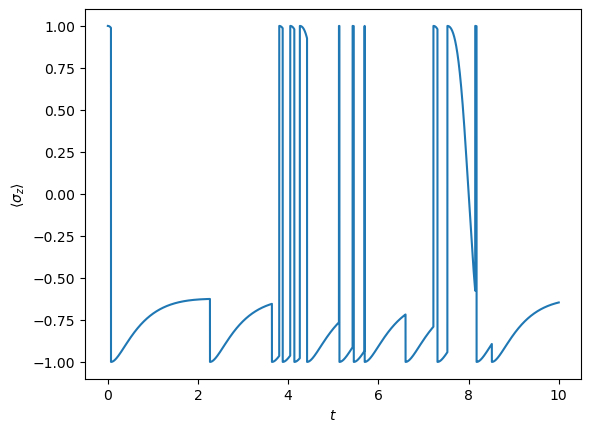

In [5]:
plt.plot(t_range, v_exp_σz)
plt.xlabel("$t$")
plt.ylabel("$\\langle\\sigma_z\\rangle$")
plt.show()

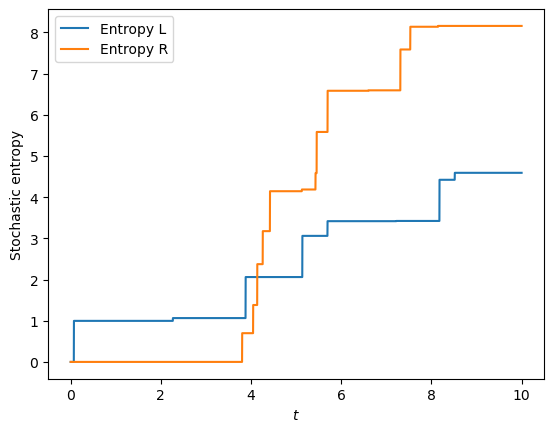

In [6]:
plt.plot(t_range, v_stoch_entropy_L, label="Entropy L")
plt.plot(t_range, v_stoch_entropy_R, label="Entropy R")
plt.xlabel("$t$")
plt.ylabel("Stochastic entropy")
plt.legend()
plt.show()

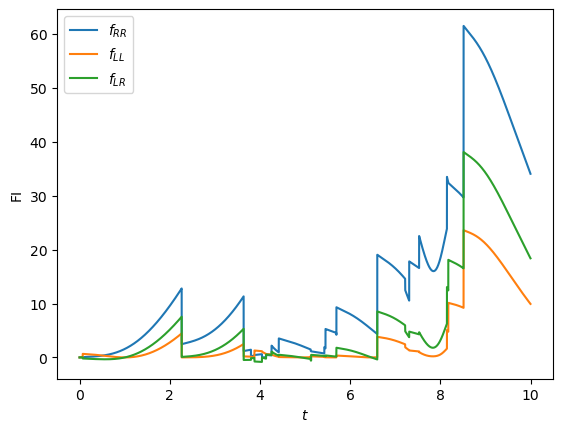

In [7]:
plt.plot(t_range, v_stoch_fRR, label="$f_{RR}$")
plt.plot(t_range, v_stoch_fLL, label="$f_{LL}$")
plt.plot(t_range, v_stoch_fLR, label="$f_{LR}$")
plt.xlabel("$t$")
plt.ylabel("FI")
plt.legend()
plt.show()

# Average over multiple trajectories

In [8]:
number_trajectories = 200

v_ave_exp_σz = np.zeros(len(t_range))
v_ave_entropy_R = np.zeros(len(t_range))
v_ave_entropy_L = np.zeros(len(t_range))
v_ave_fRR = np.zeros(len(t_range))
v_ave_fLL = np.zeros(len(t_range))
v_ave_fLR = np.zeros(len(t_range))

# Initial settings.
ψ0 = np.array([[1],[0]], dtype="complex128")
ϕL0 = np.array([[0],[0]], dtype="complex128")
ϕR0 = np.array([[0],[0]], dtype="complex128")
SL0 = 0
SR0 = 0

for trajectory in range(number_trajectories):
    ψ = ψ0
    ϕL = ϕL0
    ϕR = ϕR0
    SL = SL0
    SR = SR0
    for n_t, t in enumerate(t_range):
        ψ, ϕR, ϕL, SR, SL = execute_step(ψ, ϕR, ϕL, SR, SL)
        exp_σz = np.real(dag(ψ) @ σz @ ψ)[0][0]
        stoch_entropy_L = SL
        stoch_entropy_R = SR
        stoch_fRR = sq(np.real(dag(ψ) @ ϕR + dag(ϕR) @ ψ))**2
        stoch_fLL = sq(np.real(dag(ψ) @ ϕL + dag(ϕL) @ ψ))**2
        stoch_fLR = sq(np.real(dag(ψ) @ ϕL + dag(ϕL) @ ψ)) * sq(np.real(dag(ψ) @ ϕR + dag(ϕR) @ ψ))

        v_ave_exp_σz[n_t] += exp_σz / number_trajectories 
        v_ave_entropy_L[n_t] += stoch_entropy_L / number_trajectories
        v_ave_entropy_R[n_t] += stoch_entropy_R / number_trajectories
        v_ave_fRR[n_t] += stoch_fRR / number_trajectories
        v_ave_fLL[n_t] += stoch_fLL / number_trajectories
        v_ave_fLR[n_t] += stoch_fLR / number_trajectories
        
    print(f"Completed for trajectory {trajectory}")

Completed for trajectory 0
Completed for trajectory 1
Completed for trajectory 2
Completed for trajectory 3
Completed for trajectory 4
Completed for trajectory 5
Completed for trajectory 6
Completed for trajectory 7
Completed for trajectory 8
Completed for trajectory 9
Completed for trajectory 10
Completed for trajectory 11
Completed for trajectory 12
Completed for trajectory 13
Completed for trajectory 14
Completed for trajectory 15
Completed for trajectory 16
Completed for trajectory 17
Completed for trajectory 18
Completed for trajectory 19
Completed for trajectory 20
Completed for trajectory 21
Completed for trajectory 22
Completed for trajectory 23
Completed for trajectory 24
Completed for trajectory 25
Completed for trajectory 26
Completed for trajectory 27
Completed for trajectory 28
Completed for trajectory 29
Completed for trajectory 30
Completed for trajectory 31
Completed for trajectory 32
Completed for trajectory 33
Completed for trajectory 34
Completed for trajectory 35
Co

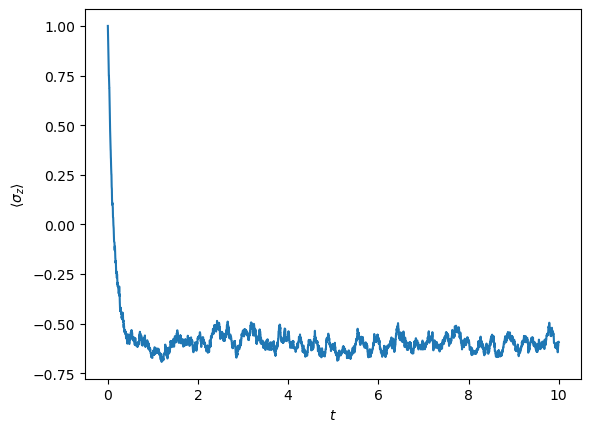

In [9]:
plt.plot(t_range, v_ave_exp_σz)
plt.xlabel("$t$")
plt.ylabel("$\\langle\\sigma_z\\rangle$")
plt.show()

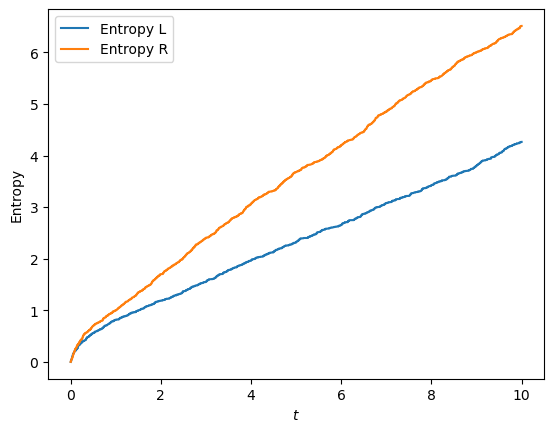

In [10]:
plt.plot(t_range, v_ave_entropy_L, label="Entropy L")
plt.plot(t_range, v_ave_entropy_R, label="Entropy R")
plt.xlabel("$t$")
plt.ylabel("Entropy")
plt.legend()
plt.show()

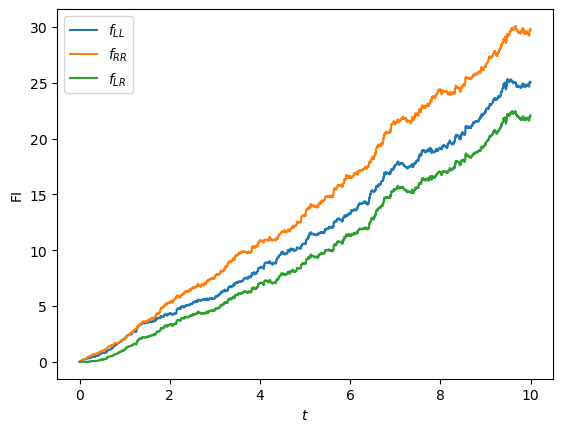

In [11]:
plt.plot(t_range, v_ave_fLL, label="$f_{LL}$")
plt.plot(t_range, v_ave_fRR, label="$f_{RR}$")
plt.plot(t_range, v_ave_fLR, label="$f_{LR}$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("FI")
plt.show()

In [12]:
v_QL = v_ave_fLL - v_ave_entropy_L
v_QR = v_ave_fRR - v_ave_entropy_R

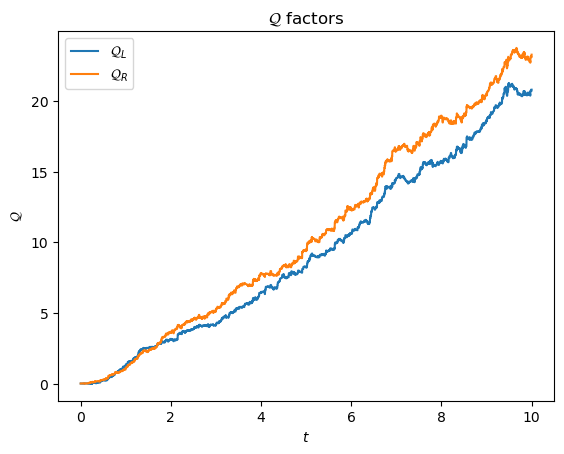

In [13]:
plt.plot(t_range, v_QL, label="$\mathcal{Q}_L$")
plt.plot(t_range, v_QR, label="$\mathcal{Q}_R$")
plt.xlabel("$t$")
plt.ylabel("$\mathcal{Q}$")
plt.title("$\mathcal{Q}$ factors")
plt.legend()
plt.show()

In [15]:
file_out = open("QuantumData.dat", "w")
file_out.write("# t \t IL \t IR \t ILR \n")
for n_t, t in enumerate(t_range):
    file_out.write(f"{t}\t{v_ave_fLL[n_t]}\t{v_ave_fRR[n_t]}\t{v_ave_fLR[n_t]}\n")
file_out.close()